# Stat Analysis 

## Repeated measures one-way ANOVA - Session Types

Repeated measures ANOVA on source data with spatio-temporal clustering

## Import

In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt

import mne
import os
import vtk

from mne.datasets import fetch_fsaverage

from mne import spatial_src_adjacency

from mne.minimum_norm import read_inverse_operator, apply_inverse

from mne.stats import (spatio_temporal_cluster_test,
                      summarize_clusters_stc, f_mway_rm, f_threshold_mway_rm)

## Main Directory

In [2]:
subjects = ['01', '12', '13', '14', '15', '17', '18', '20', '22']
sessions = ['WM1', 'WM3', 'WM5']
tasks = ['isi0', 'isi50', 'isi250', 'isi500', 'isi750', 'isi1000', 'isi1250', 'isi1500']

root_path = os.path.join("C:/Users/trevo/OneDrive/Desktop/Lab_Files/VWM_LAB")
bids_root = os.path.join(root_path, 'EGI_BIDS')
output_path = os.path.join(root_path, 'EGI_OUTPUTS')

In [3]:
stats = 'stats'
preprocessed_reports = "03_preprocessed"

#Makes EEG_OUTPUTS -> stats
if not os.path.exists(os.path.join("C:/Users/trevo/OneDrive/Desktop/Lab_Files/VWM_LAB/"+stats)):
    os.makedirs(os.path.join("C:/Users/trevo/OneDrive/Desktop/Lab_Files/VWM_LAB/"+stats))
    
stats_path = os.path.join("C:/Users/trevo/OneDrive/Desktop/Lab_Files/VWM_LAB/"+stats)

## Global Variables

In [4]:
n_subjects = 0
factor_levels=[3]
X = []

In [5]:
A1 = []
A2 = []
A3 = []

In [6]:
stcs = []

In [7]:
for subject in subjects:
    for session in sessions:
        for task in tasks:
            n_subjects+=1

## Set Parameters

In [8]:
# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

src_fname = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')

# Read the source space we are morphing to
src = mne.read_source_spaces(src_fname)

0 files missing from root.txt in C:\Users\trevo\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\trevo\mne_data\MNE-fsaverage-data\fsaverage
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read


## Statistic Pipeline

### Initialize

In [9]:
def initialize():
    printname = 'sub-'+subject+'_ses-'+session+'_task-'+task+'_preprocessed_epo.fif'
    print('######################## ['+printname+'] ########################')
    preprocessed_report_path = os.path.join(root_path, "EGI_OUTPUTS\\sub-"+subject+"\\ses-"+session+"\\eeg\\03_preprocessed")
    epochs_source_path = os.path.join(preprocessed_report_path, printname)
   
    epochs_load(epochs_source_path, printname)

### Load Epochs 

In [10]:
def epochs_load(epochs_source_path, printname):
    print('######################## Loading Epochs ########################')
    epochs = mne.read_epochs(epochs_source_path)

    epochs = epochs['WMD+', 'TsD-']
    
    print(epochs.event_id)
    
    inv_operator(epochs)

### Load Inverse Operator

In [11]:
def inv_operator(epochs):
    inv_title = 'sub-'+subject+'_ses-'+session+'_task-'+task+'-inv.fif'
    inverse_operator_path = os.path.join(root_path, "EGI_OUTPUTS\\sub-"+subject+"\\ses-"+session+"\\eeg\\06_inv")
    inv_path = os.path.join(inverse_operator_path, inv_title)

    snr = 3.0
    lambda2 = 1.0 / snr ** 2
    method = "dSPM"  # use dSPM method (could also be MNE, sLORETA, or eLORETA)
    inverse_operator = read_inverse_operator(inv_path)
    
    compute_conditions(epochs, inverse_operator, lambda2, method)

### Compute Conditions

In [12]:
 def compute_conditions(epochs, inverse_operator, lambda2, method):
    print('########################  Computing Condition ########################')
    
    evoked = epochs.average()
    evoked.resample(30).crop(0., None) #for troubleshooting, remove during analysis
    stc = apply_inverse(evoked, inverse_operator, lambda2, method)
     
    stcs.append(stc)
    
    if session == 'WM1':
        A1.append(stc.data)
    elif session == 'WM3':
        A2.append(stc.data)
    elif session == 'WM5':
        A3.append(stc.data)

## Compute Data

In [13]:
for subject in subjects:
    for session in sessions:
        for task in tasks:
            initialize()

######################## [sub-01_ses-WM1_task-isi0_preprocessed_epo.fif] ########################
######################## Loading Epochs ########################
Reading C:\Users\trevo\OneDrive\Desktop\Lab_Files\VWM_LAB\EGI_OUTPUTS\sub-01\ses-WM1\eeg\03_preprocessed\sub-01_ses-WM1_task-isi0_preprocessed_epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 127) active
    Found the data of interest:
        t =    -250.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
471 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
{'TsD-': 10001, 'WMD+': 10002}
Reading inverse operator decomposition from C:\Users\trevo\OneDrive\Desktop\Lab_Files\VWM_LAB\EGI_OUTPUTS\sub-01\ses-WM1\eeg\06_inv\sub-01_ses-WM1_task-isi0-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    126 x 126 fu

## Create Dataset

In [14]:
A1 = np.stack(A1, axis=0) # observations, space, times
A2 = np.stack(A2, axis=0) # observations, space, times
A3 = np.stack(A3, axis=0) # observations, space, times

In [16]:
A1 = np.transpose(A1, [0, 2, 1]) # observations, times, space
A2 = np.transpose(A2, [0, 2, 1]) # observations, times, space
A3 = np.transpose(A3, [0, 2, 1]) # observations, times, space

In [17]:
A1.shape

(72, 25, 20484)

In [18]:
X = [A1, A2, A3]

In [19]:
tstep = stcs[0].tstep
tstep

0.03333333333333333

In [20]:
print('F Threshold for A')
f_thresh = mne.stats.f_threshold_mway_rm(n_subjects, factor_levels = factor_levels, effects='A', pvalue=.05)
f_thresh

F Threshold for A


3.016700272452327

## Spatio-temporal Cluster Test

In [21]:
def stat_fun(*args):
    # get f-values only.
    return f_mway_rm(np.swapaxes(args, 1, 0), factor_levels=factor_levels,
                     effects='A', return_pvals=False)[0]

In [22]:
print('Computing adjacency.')
adjacency = spatial_src_adjacency(src)

n_permutations = 50

print('Clustering.')
F_obs, clusters, cluster_p_values, H0 = clu = \
    spatio_temporal_cluster_test(X, adjacency=adjacency, n_jobs=1,
                                 threshold=f_thresh, stat_fun=stat_fun,
                                 n_permutations=n_permutations,
                                 buffer_size=None)
# Now select the clusters that are sig. at p < 0.05 (note that this value
# is multiple-comparisons corrected).
good_cluster_inds = np.where(cluster_p_values < 0.05)[0]

Computing adjacency.
-- number of adjacent vertices : 20484
Clustering.
stat_fun(H1): min=0.000004 max=23.937021
Running initial clustering …
Found 2211 clusters


  0%|          | Permuting : 0/49 [00:00<?,       ?it/s]

## Visualize the Clusters

In [23]:
fsave_vertices = [s['vertno'] for s in src]

In [24]:
print('Visualizing clusters.')

#    Now let's build a convenient representation of each cluster, where each
#    cluster becomes a "time point" in the SourceEstimate
stc_all_cluster_vis = summarize_clusters_stc(clu, tstep=tstep, p_thresh=0.05,
                                             vertices=fsave_vertices,
                                             subject='fsaverage')

#    Let's actually plot the first "time point" in the SourceEstimate, which
#    shows all the clusters, weighted by duration
brain = stc_all_cluster_vis.plot(subjects_dir=subjects_dir, views='lat', hemi='both',
                                 time_label='temporal extent (ms)',
                                 clim=dict(kind='value', lims=[0, 1, 40]))
brain.save_image('clusters_two_way_statistic.png')
brain.show_view('medial')

Visualizing clusters.
Using pyvistaqt 3d backend.



## Visualize the Interaction Effect

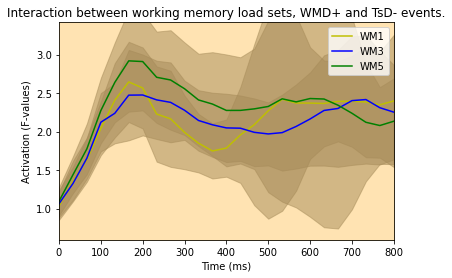

In [25]:
inds_t, inds_v = [(clusters[cluster_ind]) for ii, cluster_ind in
                  enumerate(good_cluster_inds)][0]  # first cluster

times = np.arange(X[0].shape[1]) * tstep * 1e3


plt.figure()
colors = ['y', 'b', 'g']
work_loads = ['WM1', 'WM3', 'WM5']

for ii, (condition, color, work_load) in enumerate(zip(X, colors, work_loads)):
    # extract time course at cluster vertices
    condition = condition[:, :, inds_v]
    # normally we would normalize values across subjects but
    # here we use data from the same subject so we're good to just
    # create average time series across subjects and vertices.
    mean_tc = condition.mean(axis=2).mean(axis=0)
    std_tc = condition.std(axis=2).std(axis=0)
    plt.plot(times, mean_tc.T, color=color, label=work_load)
    plt.fill_between(times, mean_tc + std_tc, mean_tc - std_tc, color='gray',
                     alpha=0.5, label='')

ymin, ymax = mean_tc.min() - .5, mean_tc.max() + .5
plt.xlabel('Time (ms)')
plt.ylabel('Activation (F-values)')
plt.xlim(times[[0, -1]])
plt.ylim(ymin, ymax)
plt.fill_betweenx((ymin, ymax), times[inds_t[0]],
                  times[inds_t[-1]], color='orange', alpha=0.3)
plt.legend()
plt.title('Interaction between working memory load sets, WMD+ and TsD- events.')
plt.show()